## 2-invariant function with ordinary graph for Max Clique Problem

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from evaluation import evaluate

Load the dataset.

In [15]:
mnist = pd.read_csv('MNIST_dataset/test.csv')
mnist.head(5)

,label,x0,y0,v0,x1,y1,v1,x2,y2,v2,...,v347,x348,y348,v348,x349,y349,v349,x350,y350,v350
0,7,14,7,254,21,18,140,21,17,106,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,17,6,253,16,19,253,10,7,253,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1,16,18,223,10,4,5,15,13,165,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,17,8,253,20,17,105,14,20,251,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,4,18,17,18,10,11,85,17,4,236,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [16]:
mnist = mnist.drop('label', axis = 1)

In [17]:
size = 100

Select 100 points randomly from an image.

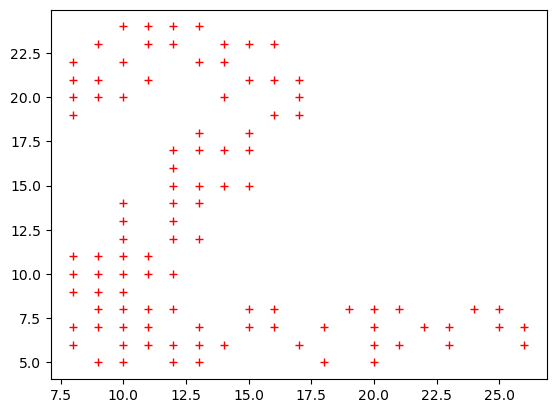

In [18]:
mapping = np.arange(3*size).reshape(-1, 3)
inds = mapping[:, :2]
val_ind = mapping[:, 2]
img = np.zeros((28, 28))
fisrt_img = mnist.to_numpy()[1]
coordinates = fisrt_img[inds]
img[coordinates[:,0], coordinates[:, 1]] = 1
plt.plot(coordinates[:,0], coordinates[:, 1], '+',color='red',)


In [36]:
mu, sigma = 0, 0.3 # mean and standard deviation
s1 = np.random.normal(mu, sigma, size)
s2 = np.random.normal(mu, sigma, size)

In [37]:
sqrt2d2 = np.sqrt(2)/2
R = np.array([[sqrt2d2, sqrt2d2], [-sqrt2d2, sqrt2d2]])
t = np.array([0.5, 0.5])
noise = np.hstack((s1.reshape(-1, 1), s2.reshape(-1, 1)))

Prepare noisy datapoints based on original data as measurements

In [38]:
from problem_instance.twoD_point_cloud_registeration import model, pairwise_compatibility_value, definite_graph, area_invariant_compatibility_test

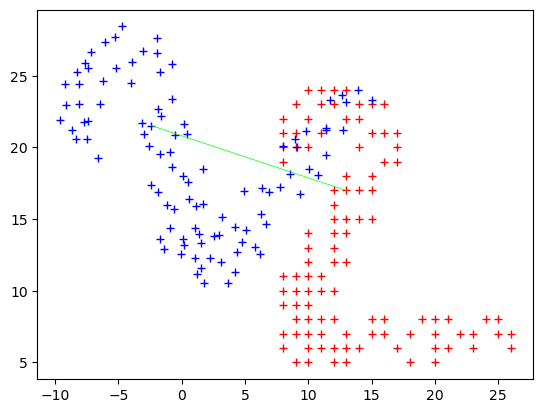

In [57]:
new_coord = model(R, t, coordinates, noise)
plt.plot(coordinates[:,0], coordinates[:, 1], '+', color='red')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='blue',)

plt.plot([coordinates[0,0], new_coord[0,0]], [coordinates[0,1], new_coord[0,1]], linewidth=0.5, color='lime')

Replace with 20% outliers 

In [40]:
outlier_rate = 0.2
outliers = 28 * np.random.rand(int(size*outlier_rate), 2) # 20 outliers points in 2D
outliers_cord_t = model(R, t, outliers, np.zeros((20, 2)))

In [41]:
new_coord_with_outliers = np.vstack((new_coord[:-20], outliers_cord_t))
inlier_mask = np.zeros(size, dtype=bool)
inlier_mask[:-20] = True

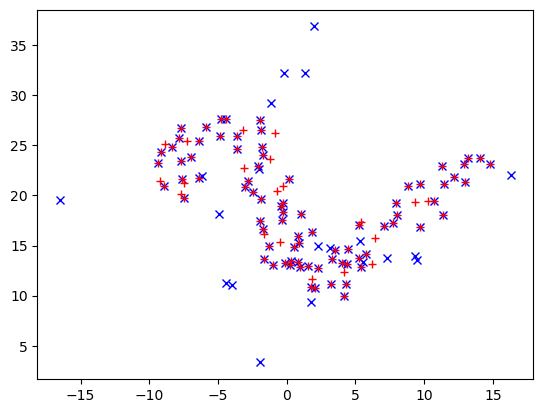

In [42]:
plt.plot(new_coord_with_outliers[:,0], new_coord_with_outliers[:, 1], 'x', color='blue')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='red')

Shuffle measurements and datapoints

In [43]:
perm = np.random.permutation(size)
inlier_perm_mask = inlier_mask[perm]
new_coord_with_outliers = new_coord_with_outliers[perm]
coordinates = coordinates[perm]

In [44]:
acceptance = 5.54*sigma # we generate the noise based on Gaussian distribution
beta = np.linalg.norm((acceptance, acceptance)) # threshold for 2d compatibility test

In [45]:
weigthed_G = pairwise_compatibility_value(coordinates, new_coord_with_outliers)
G = definite_graph(weigthed_G, beta)

In [46]:
from QUBO_formulation.qubo import solve_graph, definite_graph_to_qubo, weighted_graph_to_qubo, n_invariant_ordinary_graph_to_qubo

Simulated Annealing Solver

In [47]:
sl = solve_graph(G, "dwave_annealing", penalty_reg=2) #penalty as suggested in the paper

In [48]:
sol = np.argwhere(sl == 1).reshape(-1)

In [72]:
solution_mask = np.zeros(size, dtype=bool)
solution_mask[sol] = True

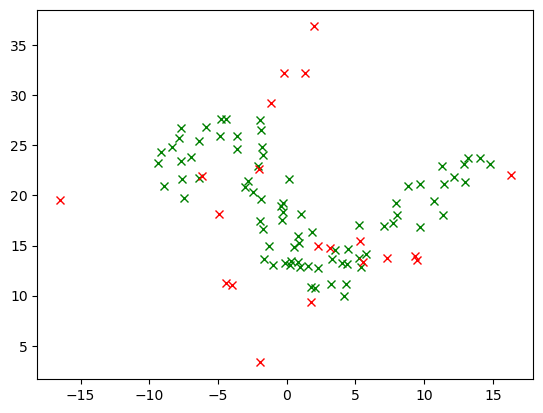

In [80]:
plt.plot(new_coord_with_outliers[inlier_perm_mask, 0], new_coord_with_outliers[inlier_perm_mask, 1], 'x', color='green')
plt.plot(new_coord_with_outliers[~inlier_perm_mask, 0], new_coord_with_outliers[~inlier_perm_mask, 1], 'x', color='red')

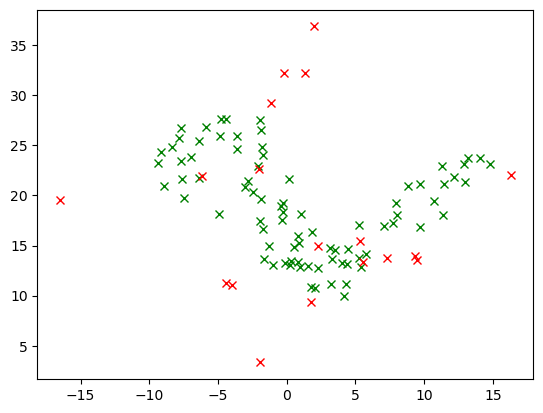

In [79]:
plt.plot(new_coord_with_outliers[sol, 0], new_coord_with_outliers[sol, 1], 'x', color='green')
plt.plot(new_coord_with_outliers[~solution_mask, 0], new_coord_with_outliers[~solution_mask, 1], 'x', color='red')
# plt.plot(coordinates[:,0], coordinates[:, 1], '+', color='red')
# plt.plot([coordinates[sol,0], new_coord[sol,0]], [coordinates[sol,1], new_coord[sol,1]], linewidth=0.2, color='green');
# plt.plot([coordinates[~solution_mask,0], new_coord[~solution_mask,0]], [coordinates[~solution_mask,1], new_coord[~solution_mask,1]], linewidth=0.5, color='red');

In [50]:
evaluate(size, inlier_perm_mask, sl)

Overall Accuracy:  0.98
Inlier Preserved Rate:  1.0
Outlier Rejected Rate:  0.9


(0.98, 1.0, 0.9)

Gurobi Optimizer

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model fingerprint: 0x1511f5ad
Model has 1113 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [8e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Found heuristic solution: objective -82.0000000
Presolve time: 0.00s
Presolved: 18 rows, 118 columns, 1149 nonzeros
Variable types: 0 continuous, 118 integer (100 binary)

Root relaxation: objective -8.362399e+01, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Ti

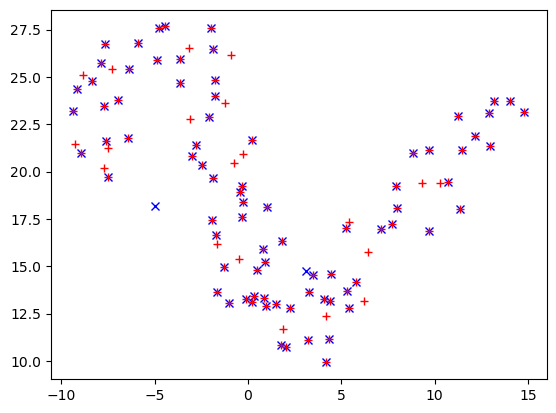

In [51]:
slg = solve_graph(G, "gurobi", penalty_reg=2)
solg = np.argwhere(sl == 1).reshape(-1)
plt.plot(new_coord_with_outliers[solg, 0], new_coord_with_outliers[solg, 1], 'x', color='blue')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='red')

In [52]:
evaluate(size, inlier_perm_mask, slg)

Overall Accuracy:  0.98
Inlier Preserved Rate:  1.0
Outlier Rejected Rate:  0.9


(0.98, 1.0, 0.9)